In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [102]:
review_json_path = 'normalized.json'

In [103]:
df_reviews = pd.read_json('normalized.json')
df_japanese = pd.read_json('jap.json')

## Label Sentiment of Reviews

We will assign labels to our reviews based on the reviews' star rating. All reviews 3 stars and under will be considered a negative review and those 4 stars and above as positive, in order to avoid neutrality. 

In [104]:
df_japanese['sentiment'] = df_japanese['review_stars'].apply(lambda rating : +1 if rating > 3 else 0)

In [105]:
new_df = df_japanese[['text', 'sentiment']]

In [106]:
new_df.head()

,text,sentiment
301,"""River, we see that you haven't Yelped in a wh...",1
302,Gave this restaurant 3 stars mostly because of...,0
303,Oh boy! I love veggie restaurants! Especially ...,1
304,This was my first vegan meal! I went with the ...,1
305,Visited the Veggie House today. The atmosphe...,1


## Preprocessing Pipeline

In [107]:
wpt = nltk.WordPunctTokenizer()

In [108]:
stop_words=nltk.corpus.stopwords.words('english')

In [109]:
def normalize_document (document): 
    document=re.sub(r'[^a-zA-Z\s]', ' ', document, re.I|re.A)
    document=document.lower()
    document=document.strip()
    
    tokens = wpt.tokenize(document)
    filtered_tokens = [ token for token in tokens if token not in stop_words]
    
    document = ' '.join(filtered_tokens)
    return document

In [110]:
text_column = new_df['text']
normalize_corpus=np.vectorize(normalize_document)
norm_corpus = normalize_corpus(text_column)

In [111]:
new_df['text_preprocessed'] = norm_corpus

<ipython-input-111-904768bd804a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['text_preprocessed'] = norm_corpus


In [112]:
X = new_df['text_preprocessed']
y = new_df['sentiment']

In [113]:
X.shape, y.shape

((148224,), (148224,))

In [114]:
norm_corpus = X.tolist()
y = y.values

In [115]:
type(norm_corpus), type(y)

(list, numpy.ndarray)

## Saving Normalized Data

In [116]:
with open ('X.pickle','wb') as f:#wb, write-byte
    pickle.dump (X,f)

In [117]:
with open ('y.pickle','wb') as f:#wb, write-byte
    pickle.dump (y,f)

In [139]:
with open ('norm_corpus.pickle', 'wb') as f: 
    pickle.dump(norm_corpus,f)

## Bag of Words

In [119]:
vectorizer = CountVectorizer(max_features=2000,min_df=3, max_df=0.8, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(norm_corpus).toarray()

In [121]:
type(vectorizer)

sklearn.feature_extraction.text.CountVectorizer

## Convert BOW to TFIDF

In [122]:
transformer = TfidfTransformer(norm='l2', use_idf=True)

In [123]:
X=transformer.fit_transform(X).toarray()

## Split Data

In [124]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=1)

In [125]:
train_X.shape

(118579, 2000)

In [126]:
train_y.shape

(118579,)

In [127]:
valid_X.shape

(29645, 2000)

In [128]:
valid_y.shape

(29645,)

## Logistic Regression

In [129]:
classifier = LogisticRegression(max_iter=500)
classifier.fit(train_X,train_y) 

LogisticRegression(max_iter=500)

In [130]:
y_pred = classifier.predict(valid_X) #list of all preditions

## Model Evaluation

In [131]:
#Now we need to compare sent_pred with sent_test
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_y,y_pred)

In [132]:
cm

array([[ 5744,  1597],
       [  848, 21456]])

In [133]:
from sklearn.metrics import accuracy_score
accuracy_score (valid_y,y_pred)

0.9175240344071512

In [134]:
from sklearn.metrics import recall_score
recall_score (valid_y,y_pred)

0.9619799139167863

In [135]:
from sklearn.metrics import f1_score
f1_score (valid_y,y_pred)

0.9460943184073021

In [136]:
#total correct predictions out of 29645
tot=cm[0][0]+cm[1][1]
print (tot)
#Model accuracy
print("Accuracy:",(tot/cm.sum()))

27200
Accuracy: 0.9175240344071512


In [96]:
#Model precision
prec=round((cm[1][1]/(cm[1][1]+cm[0][1])),4)
print ("Precision:",prec)

Precision: 0.9307


In [97]:
#Model recall - hit rate
rec=round((cm[1][1]/(cm[1][1]+cm[1][0])),4)
print ("Recall:",rec)

Recall: 0.962


In [98]:
#Model F1-score - hit rate
F1_score = round(2*prec*rec/(prec+rec),4)
print ("F1 Score:",F1_score)

F1 Score: 0.9461


In [100]:
print(classification_report(valid_y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      7341
           1       0.93      0.96      0.95     22304

    accuracy                           0.92     29645
   macro avg       0.90      0.87      0.89     29645
weighted avg       0.92      0.92      0.92     29645



## Feature Importantance

In [137]:
feature_importance=pd.DataFrame({'feature':vectorizer.get_feature_names(),'feature_importance':classifier.coef_[0]})
feature_importance=feature_importance.sort_values('feature_importance',ascending=False).head(10)

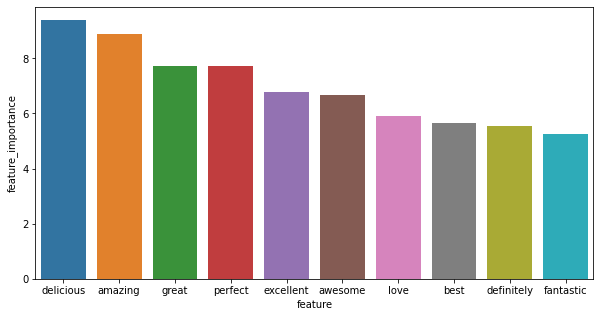

In [138]:
plt.figure(figsize=(10,5))
sns.barplot(x=feature_importance['feature'], y=feature_importance['feature_importance'])

## Saving our Classifier

In [ ]:
with open ('classifier.pickle','wb') as f:#rb, write-byte
    pickle.dump(classifier,f)

## Applying our Classifier

Creating and saving TFIDFVectorizer

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000, min_df=3,max_df=0.6,stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(norm_corpus).toarray()

In [ ]:
with open ('tfidfmodel.pickle','wb') as f:#rb, write-byte
    pickle.dump(vectorizer,f)

Importing the Vectorizer and Classifier

In [ ]:
with open ('classifier.pickle','rb') as f:#rb, read-byte
    clf=pickle.load(f)
with open ('tfidfmodel.pickle','rb') as f:#rb, read-byte
    tfidf=pickle.load(f)

Negative Review test

In [ ]:
sample_1 = ['We just there few minutes ago and we ordered two item combos disappointed sad that when I got home the food we ordered has missing items. Our combos included a Bicol Express (not sure if I say it right) but all has pork inside not even a single shrimp or squid included... and most specially the soup we ordered  was not in the bag. The cashier should have a somewhat somebody helping her to pack up the food to keep the line going ... very disappointed and this happened twice.']
sample_1 = tfidf.transform(sample_1).toarray()

In [ ]:
print("0 is negative & 1 is positive:", clf.predict(sample_1)) 

Positive Review test

In [ ]:
sample_2 = ['I have been to KazuNori multiple times (pre- and post- pandemic) and have recently tried the take out. I just want to say that dinning in is much better than taking out. Even if theres a wait or a line, its worth it to dine-in! As it says in the name, this is a hand roll bar. The take out is not bad, but theres just something about getting that crispy, fresh handroll! Review for takeout: I got the  I think the issue is that, the seaweed is not as fresh and crispy as when the roll it fresh for you. I thought the box was super cute and everything is packed nicely for you. I also enjoyed the salmon sashimi, they give a nice yuzu sauce that compliments it quite well. Some of my favorite rolls are the crab and the salmon! I would definitely recommend those ones : )']
sample_2 = tfidf.transform(sample_2).toarray()

In [ ]:
print("0 is negative & 1 is positive:", clf.predict(sample_2)) 